In [1]:
library(plyr)
source("../data/env/variables.R")
source("~/wisdom/r/data_analysis_environment.R")
options(repr.plot.width=10, repr.plot.height=8)
library(cowplot)

switches.split <- read_tsv("../data/pancancer/candidateList_full.tumorSplit.tsv")

switches <- read_tsv("../data/pancancer/candidateList_full.tsv") %>%
    filter(Reliable==1 & Origin=="Tumor")

drivers <- read_tsv("../data/intogen_cancer_drivers-2014.12b/Mutational_drivers_per_tumor_type.tsv",comment="#") %>%
  mutate(Tumor_type = ifelse(Tumor_type=="COREAD", "coad", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="HC", "lihc", Tumor_type),
         Tumor_type = ifelse(Tumor_type=="RCCC", "kirc", Tumor_type),
         Tumor_type = tolower(Tumor_type) ) %>%
  set_colnames(c("Symbol","Tumor"))

proteome <- read_tsv("../data/mutations/proteome_information.txt") %>%
    mutate(asEvidence = asEvidence == "True")

# read mutations
wes <- read_tsv("../data/mutations/wes_mutations.txt") %>%
    select(Tumor,GeneId,Symbol,Patient) %>%
    unique

wgs <- read_tsv("../data/mutations/wgs_mutations.txt") %>%
    select(Tumor,GeneId,Symbol,Patient) %>%
    unique


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, last

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract


Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



In [2]:
getBoxplotAsterisks <- function(stat.tests,ranges,rm.outliers=TRUE,categories=cancerTypes){
  
  if (rm.outliers){
    plotRanges <- ddply(ranges, .(Cancer,Categories), summarise, Q1=quantile(y, 1/4), Q3=quantile(y, 3/4), IQR=Q3-Q1, upper.limit=Q3+1.5*IQR)
    plotRanges <- ddply(plotRanges, .(Cancer), summarise, y=max(upper.limit))
  } else {
    plotRanges <- ddply(ranges, .(Cancer), summarise, y=max(y))
  }
  
  minStep <- max(plotRanges$y)/40
  
  r <- 0.25
  t <- seq(0, 180, by = 1) * pi / 180
  x <- r * cos(t)
  y <- minStep * sin(t)
  y[which(y>minStep/2)] <- minStep/2
  modelArc <- data.frame(x = x, y = y)
  
  arcs <- data.frame(Cancer=character(),x_arc=numeric() ,y_arc=numeric())
  ast <- data.frame(Cancer=character(),x_ast=numeric() ,y_ast=numeric())
  for (kns in stat.tests$Cancer[stat.tests$p < 0.05]){
    i <- which(categories==kns)
    j <- max(plotRanges$y[plotRanges$Cancer==kns])
    tmp_arc <- data.frame(Cancer=i, x_arc=modelArc$x+(i), y_arc=modelArc$y+j)
    arcs <- rbind(arcs,tmp_arc)
    
    tmp_ast <- data.frame(Cancer=i,x_ast=i ,y_ast=j + 1.2*minStep)
    ast <- rbind(ast,tmp_ast)
  }
  
  significanceElements <- list("asterisks" = ast, "arcs" = arcs)
  
  return(significanceElements)
  
}

# isoform lengths
lengths.random <- read_tsv("../data/switches/isoform_length.random.tsv") %>%
    mutate(nIsoLength = ifelse(nIsoLength==0, NA, nIsoLength),
           tIsoLength = ifelse(tIsoLength==0, NA, tIsoLength),
           Random = ifelse(Random == "NonRandom", "Observed", "Random switches"))
lengths.observed <- read_tsv("../data/switches/isoform_length.nonRandom.tsv") %>%
    mutate(nIsoLength = ifelse(nIsoLength==0, NA, nIsoLength),
           tIsoLength = ifelse(tIsoLength==0, NA, tIsoLength),
           Random = ifelse(Random == "NonRandom", "Observed", "Random switches")) %>%
    # filter out unwanted switches
    merge(switches.split %>% filter(Reliable==1 & Origin=="Tumor"))

lengths <- list("Random switches" = lengths.random, "Observed" = lengths.observed)

figs <- list()
for (r in c("Observed", "Random switches")){
  
    this.isoLengths <- lengths[[r]]
    
    isoLengths.melt <- this.isoLengths %>%
        select(Tumor, nIsoLength, tIsoLength) %>% 
        reshape2::melt(id.vars = "Tumor", variable.name = "IsoformOrigin", value.name = "Length") %>% 
        mutate(IsoformOrigin = ifelse(IsoformOrigin == "nIsoLength", "Normal", "Tumor"))
  
    # get ranges and convert to log10 scale
    tumorEnrichment <- this.isoLengths %>%
        group_by(Tumor) %>%
        summarise(p = t.test(nIsoLength,tIsoLength,paired=TRUE,alternative="greater")$p.value )
    
    ranges <- isoLengths.melt %>%
        mutate(Length = log10(Length)) %>%
        filter(!is.na(Length)) %>%
        set_colnames(c("Cancer","Categories","y"))
  
    sigElements <- this.isoLengths %>%
        filter(!is.na(nIsoLength) & !is.na(tIsoLength)) %>%
        group_by(Tumor) %>%
        summarise(mean_nIso = mean(nIsoLength),
                  mean_tIso = mean(tIsoLength),
                  mean_diff = mean(nIsoLength-tIsoLength)) %>%
        merge(tumorEnrichment) %>%
        set_colnames(c("Cancer","mean_nIso","mean_tIso", "mean_diff","p")) %>%
        getBoxplotAsterisks(ranges,rm.outliers=T)
  
    # plot isoform length
    p <- ggplot(isoLengths.melt) + 
        geom_boxplot(aes(factor(Tumor),log10(Length),fill=IsoformOrigin), outlier.colour = NA) + 
        labs(x="Tumor",y="log10(length)",fill="Isoform") +
        scale_fill_manual(values=c("#d95f02","#7570b3")) +
        theme(legend.position="bottom", axis.text.x = element_text(angle = 90, hjust = 1))
  
    if (! empty(sigElements$asterisks) || ! empty(sigElements$arcs) ){
        p <- p + 
            geom_text(data=sigElements$asterisks ,aes(x=x_ast,y=y_ast,label='*'),size=15) + 
            geom_line(data=sigElements$arcs, aes(x_arc,y_arc,group=Cancer))
    }
  
    figs[[r]] <- p
  
}

sf1a <- figs[["Observed"]]
sf1b <- figs[["Random switches"]]

ggsave("../results/figures/components/s1a.png",sf1a)
ggsave("../results/figures/components/s1b.png",sf1b)

Saving 7 x 7 in image
Warning message:
: Removed 3025 rows containing non-finite values (stat_boxplot).Saving 7 x 7 in image
Warning message:
: Removed 436503 rows containing non-finite values (stat_boxplot).

In [10]:
library(scales)
library(ggstars)

proteome.drivers <- proteome %>%
    filter(asEvidence) %>%
    mutate(Driver = as.numeric(Symbol %in% drivers$Symbol) ) %>%
    select(Tumor,GeneId, Driver)
    
proteome.switches <- proteome %>%
    filter(asEvidence) %>%
    merge(switches.split %>% filter(Reliable==1 & IsFunctional==1 & Origin=="Tumor")) %>%
    select(Tumor,GeneId) %>%
    mutate(Switch=1)

driver.enrichment <- proteome %>%
    filter(asEvidence) %>%
    merge(proteome.drivers, all.x=T) %>%
    merge(proteome.switches, all.x=T) %>%
    mutate(Driver = ifelse(is.na(Driver), 0, Driver),
           Switch = ifelse(is.na(Switch), 0, Switch)) %>%
    group_by(Tumor) %>%
    summarise(SwDr = sum(Driver==1 & Switch==1),
              NSwDr = sum(Driver==1 & Switch==0),
              SwNDr = sum(Driver==0 & Switch==1),
              NSwNDr = sum(Driver==0 & Switch==0))

driver.enrichment <- apply(driver.enrichment[,2:5],1,function(x){
    f <- fisher.test(matrix(x,2,2))
    p <- f$p.value
    OR <- as.numeric(f$estimate)
    c(p=p,OR=OR)
}) %>% t%>% as.data.frame %>%
    cbind(driver.enrichment,.)

driver.enrichment.melt <- driver.enrichment %>%
    select(-p, -OR) %>%
    melt(id.vars="Tumor") %>%
    mutate( Driver = ifelse(variable %in% c("SwDr","NSwDr"), "Driver", "Non-driver"),
            Switch = ifelse(variable %in% c("SwDr","SwNDr"), "Switch", "No switch"),
            Tag = paste(Tumor, Driver, sep="_"))

axisLabels <- strsplit(driver.enrichment.melt$Tag, "_") %>% unlist %>% .[c(F,T)]
names(axisLabels) <- driver.enrichment.melt$Tag

sf1c <- ggplot(driver.enrichment.melt , aes(x=Tag, y=value, fill=Tumor, alpha=Switch)) +
    geom_bar(stat="identity",position="fill") +
    labs(x="", y="% switched") +
    scale_fill_manual(values = colorPalette) +
    scale_alpha_manual(values = c("Switch"=1, "No switch"=0), guide = FALSE) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=axisLabels) +
    scale_y_continuous(labels = percent)
sf1c <- star_bar(sf1c, driver.enrichment$p < 0.05)

ggsave("../results/figures/components/s1c.png",sf1c)

Saving 7 x 7 in image


Warning message:
: Removed 3025 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 436503 rows containing non-finite values (stat_boxplot).

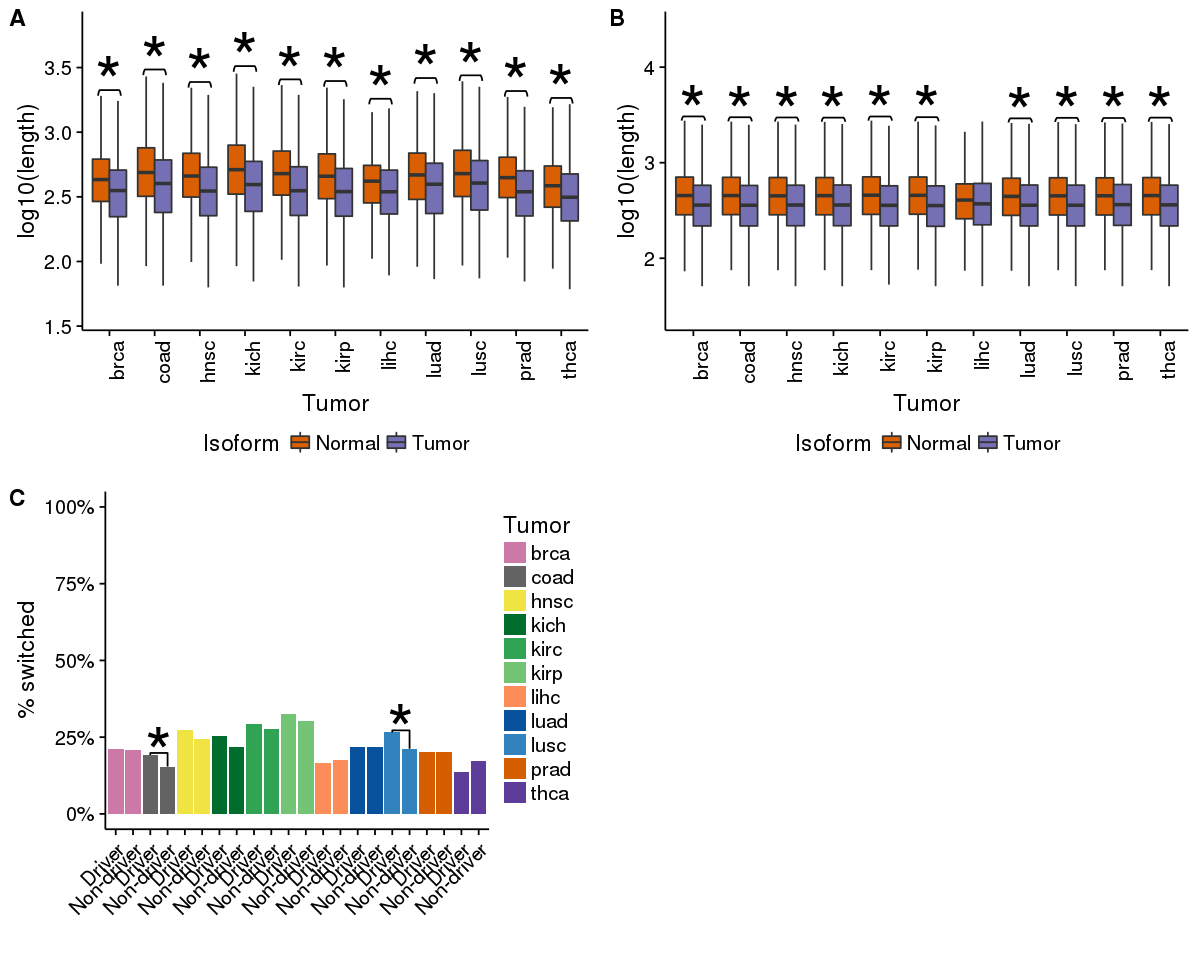

In [11]:
sf1 <- plot_grid(sf1a,sf1b,sf1c, labels=c("A","B","C"))
sf1
ggsave("../results/figures/suppfigure_1.png",sf1, width = 10, height = 8)

**Supplementary Figure 1. (A)** Distributions of the lengths of the tumor and normal isoforms in the calculated alternative splicing switches. **(B)** Distributions of the lengths of the tumor and normal isoforms in the simulated alternative splicing switches. **(C)** Distributions of the number of patients across all tumor types (y-axis, in log10 scale) where functional (left) and non-functional (right) switches occur. **(D)** For each tumor type, we give the proportions of genes with alternative transcript isoforms that present a switch, separated according to whether they are cancer drivers (Methods) or not. Except for liver and prostate tumors, in all cases there is a higher proportion of drivers with switches. We indicate with asterisk those cases that are statistically significant. 

In [5]:
# count number of genes altered per patient
## WES mutation
genesPAM.perPatient <- wes %>%
    group_by(Tumor,Patient) %>%
    summarise(PAM=n())

## WGS mutation
genesMutated.perPatient <- wgs %>%
    group_by(Tumor,Patient) %>%
    summarise(WGS=n())

## a functional switch
genesSwitched.perPatient <- switches$Patients_affected[switches$IsFunctional==1] %>%
    strsplit(",") %>% unlist %>%
    table %>% as.data.frame %>%
    set_colnames(c("Patient","Switch"))

# use number of spliced genes and total number of genes to normalize the observations
consideredGenes <- proteome %>%
    group_by(Tumor) %>%
    summarise(SplicedGenes = sum(asEvidence), Genes = n())

recurrence <- merge(genesSwitched.perPatient,genesPAM.perPatient,all=T) %>%
    merge(genesMutated.perPatient,all=T) %>%
    merge(consideredGenes) %>%
    mutate(PAM=PAM/Genes, WGS=WGS/Genes,
           Switch=Switch/SplicedGenes) %>%
    select(everything(),-contains("Genes"))

# show distribution of genes affected through each mechanism per patient
sf2a <- recurrence %>%
    melt %>%
    set_colnames(c("Tumor","Patient","Alteration","Proportion")) %>%
    ggplot(aes(x=Tumor,y=Proportion, fill=Alteration)) +
        geom_boxplot() + 
        scale_y_log10() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1))
ggsave("../results/figures/components/s2a.png",sf2a)

Using Tumor, Patient as id variables
Saving 7 x 7 in image
Warning message:
: Removed 4546 rows containing non-finite values (stat_boxplot).

In [6]:
# count number of genes altered per patient
## WES mutation
samplesPAM.perGene <- wes %>%
    group_by(Tumor,GeneId) %>%
    summarise(PAM = n())

## WGS mutation
samplesMutated.perGene <- wgs %>%
    group_by(Tumor,GeneId) %>%
    summarise(WGS = n())

## a functional switch
samplesSwitched.perGene <- switches.split %>%
    filter(IsFunctional==1) %>%
    select(Tumor,GeneId,PatientNumber) %>%
    group_by(Tumor,GeneId) %>%
    summarise(Switch=sum(PatientNumber)) %>%
    set_colnames(c("Tumor","GeneId","Switch"))

# use number of patients per tumor to normalize the observations
wesPatients <-  wes %>%
    select(Tumor,Patient) %>% unique %>%
    group_by(Tumor) %>%
    summarise(WESPatients = n())

wgsPatients <-  wgs %>%
    select(Tumor,Patient) %>% unique %>%
    group_by(Tumor) %>%
    summarise(WGSPatients = n())

splicingPatients <- do.call("rbind",nPatients) %>%
    as.data.frame %>%
    set_colnames("SplicingPatients") %>%
    mutate(.,Tumor=rownames(.)) %>%
    filter(Tumor!="total")

patients <- merge(wesPatients,wgsPatients,all=T) %>%
    merge(splicingPatients,all=T)

geneIncidence <- merge(samplesSwitched.perGene,samplesPAM.perGene,all=T) %>%
    merge(samplesMutated.perGene,all=T) %>%
    merge(patients) %>%
    mutate(PAM=PAM/WESPatients, WGS=WGS/WGSPatients,
           Switch=Switch/SplicingPatients) %>%
    select(everything(),-contains("Patients"))

# show distribution of samples affected through each mechanism per gene
sf2b <- geneIncidence %>%
    melt(c("Tumor","GeneId")) %>%
    set_colnames(c("Tumor","GeneId","Alteration","Proportion")) %>%
    ggplot(aes(x=Tumor,y=Proportion, fill=Alteration)) +
        geom_boxplot() + 
        scale_y_log10() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1))

ggsave("../results/figures/components/s2b.png",sf2b)

Saving 7 x 7 in image
Warning message:
: Removed 233397 rows containing non-finite values (stat_boxplot).

In [7]:
sf2c <- recurrence %>%
    ggplot(aes(x=Switch,y=PAM,color=Tumor)) + 
    geom_point() + 
    geom_smooth(color="black") +
    scale_y_log10() +
    scale_x_log10() +
    scale_color_manual(values=colorPalette) + 
    labs(x="Genes with a functional switch", y="Genes with a PAM") +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    facet_wrap(~ Tumor)

ggsave("../results/figures/components/s2c.png",sf2c)

Saving 7 x 7 in image
Warning message:
: Removed 485 rows containing non-finite values (stat_smooth).Warning message:
: Removed 485 rows containing missing values (geom_point).

In [8]:
# prepare data
## read ME with top drivers
me <- lapply(1:10, function(i){
  read_tsv(paste0("../data/mutations/pannegative_mutual_exclusion.top_",i,"_drivers.txt")) %>%
    mutate(NumDrivers = i, Total = M + MS + S + N,
           M.p = M/Total, MS.p = MS/Total, 
           S.p = S/Total, N.p = N/Total,
           SwitchSamples = S + MS)
  }) %>% do.call("rbind",.)

potus.pn <- switches %>%
    filter(Candidate==1 & Pannegative > 0 & Origin=="Tumor") %>%
    merge(me) %>%
    filter(p.me < 0.05) %>%
    by(., paste0(.$GeneId,.$Tumor), 
         function(X) X[which.max(X$NumDrivers),]) %>%
    do.call("rbind",.)
             
## order genes by total number of patients explained
df <- potus.pn %>%
    select(Tumor,GeneId,Symbol,Normal_transcript,Tumor_transcript,MS.p,M.p,S.p) %>%
    mutate(Switch = as.character(paste(Tumor,Symbol,Normal_transcript,Tumor_transcript))) %>%
    arrange(-(MS.p+M.p+S.p)) %>%
    mutate(Switch = factor(Switch,levels=Switch)) %>%
    select(Tumor,Switch,M.p,MS.p,S.p) %>%
    top_n(30) %>%
    # show in detail the 30 cases where more patients are explained
    reshape2::melt(id.vars=c('Tumor','Switch')) %>%
    mutate(variable = plyr::revalue(variable, c("M.p"="M","MS.p"="MS","S.p"="S")),
           variable = factor(variable,levels=c("M","MS","S")),
           Symbol = Switch %>% as.character %>% strsplit(" ") %>% unlist %>% .[c(F,T,F,F)])
             
labels <- df$Symbol
names(labels) <- df$Switch
sf2d <- ggplot(df, aes(x=Switch,y=value, alpha=variable, fill=Tumor)) +
    geom_bar(stat="identity") +
    labs(x="", y="Patients explained", alpha="Patient type") +
    scale_fill_manual(values = colorPalette) +
    scale_y_continuous(labels = percent) +
    scale_x_discrete(labels = labels) +
    theme(axis.text.y=element_text(size=8), axis.text.x = element_text(angle = 90)) +
    coord_flip()
             
ggsave("../results/figures/components/s2d.png",sf2d)

Selecting by S.p
Saving 7 x 7 in image


Warning message:
: Removed 4546 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 233397 rows containing non-finite values (stat_boxplot).Warning message:
: Removed 485 rows containing non-finite values (stat_smooth).Warning message:
: Removed 485 rows containing missing values (geom_point).

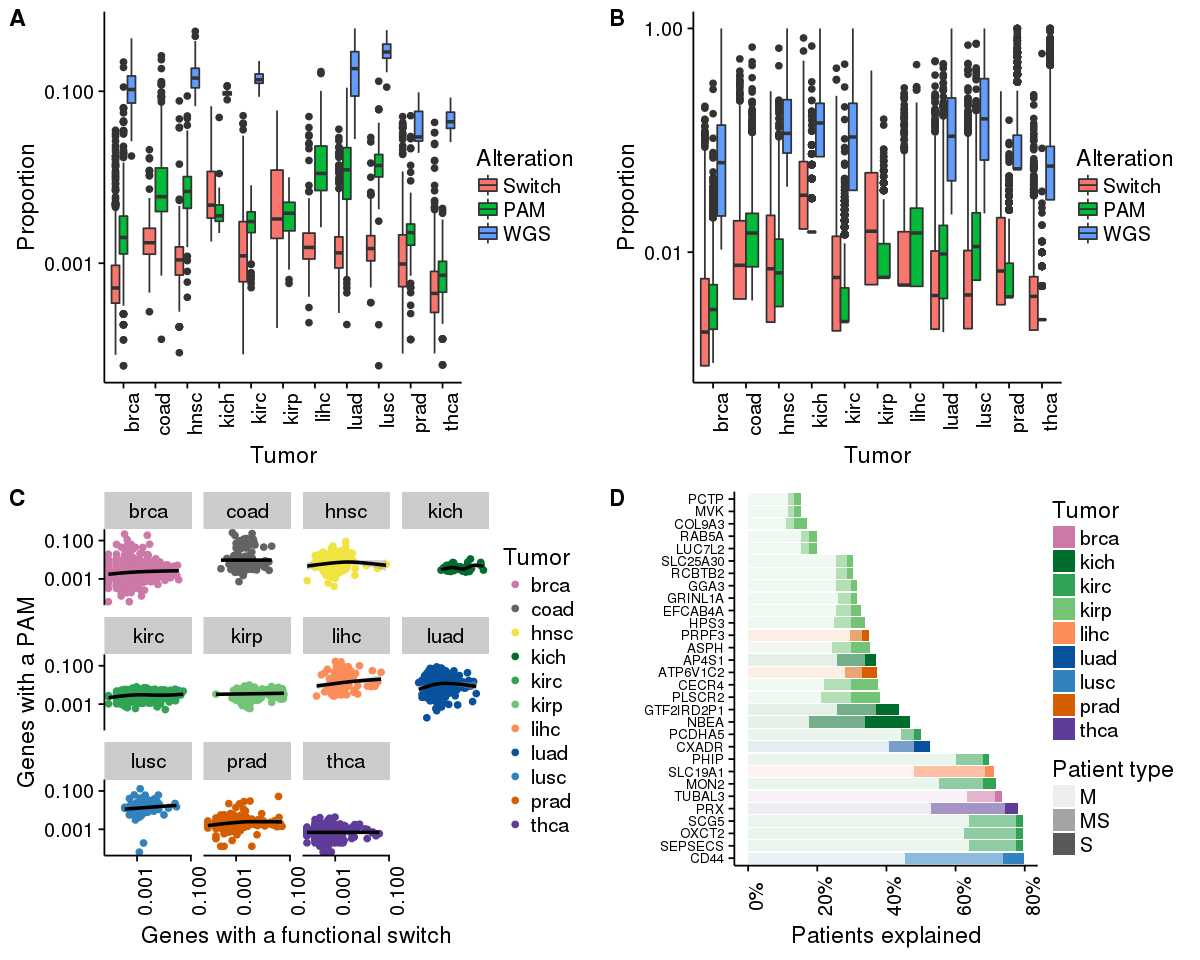

In [9]:
sf2 <- plot_grid(sf2a,sf2b,sf2c,sf2d, labels=c("A","B","C","D"))
sf2
ggsave("../results/figures/suppfigure_2.png",sf2, width = 10, height = 8)

**Supplementary Figure 2. (A)** Proportion of genes in log10 scale (y axis) with either of the three alterations: isoform switches (red), protein affecting mutations (PAM) (green), and any mutation from whole genome sequencing data (WGS) (blue). **(B)** Proportion of samples (y axis) with either of the three studied alterations: isoform switches (red), protein affecting mutations (PAM) (green), and any mutation from whole genome sequencing data (WGS) (blue). **(C)** No correlation between PAMs and switches. In each tumor type, each dot represents a sample according to the number of genes with a functional switch (x axis) and the number of genes with protein affecting mutations (PAM) (y axis). **(D)** Functional switches that potentially characterize pan-negative tumor samples. For each switch along the x-axis, we represent the proportion of patients from a given tumor type that harbor mutations in a tumor-specific Mut-driver (M), has the switch (S), or both (MS). The switches are ranked along the x-axis according to the total number of patients explained. Each case is colored according to tumor type. 